<a href="https://colab.research.google.com/github/it21813702/ML_Assignment_1/blob/main/ML_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Loading and Initial Exploration

In [1]:
# import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')


In [2]:
# load the dataset
df = pd.read_csv('Loan_default.csv')

# print some basic infor about the dataset
print("dataset shape:", df.shape)

# print the initial rows of the dataset, can specidy how many by including a num in the brackets
df.head(3)


dataset shape: (118588, 18)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36.0,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0.0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60.0,0.68,Master's,Full-time,Married,No,No,Other,Yes,0.0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24.0,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1.0



Missing Values per column: 
LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          1
DTIRatio          1
Education         1
EmploymentType    1
MaritalStatus     1
HasMortgage       1
HasDependents     1
LoanPurpose       1
HasCoSigner       1
Default           1
dtype: int64

Summary statistics:
                 Age         Income     LoanAmount    CreditScore  \
count  118588.000000  118588.000000  118588.000000  118588.000000   
mean       43.516823   82529.857625  127589.693578     574.108350   
std        14.974214   39005.130449   70852.325096     158.804077   
min        18.000000   15000.000000    5005.000000     300.000000   
25%        31.000000   48716.250000   66156.750000     436.000000   
50%        43.500000   82578.500000  127455.000000     574.000000   
75%        56.000000  116278.250000  188973.250000     711.000000   
max        69.000000  149

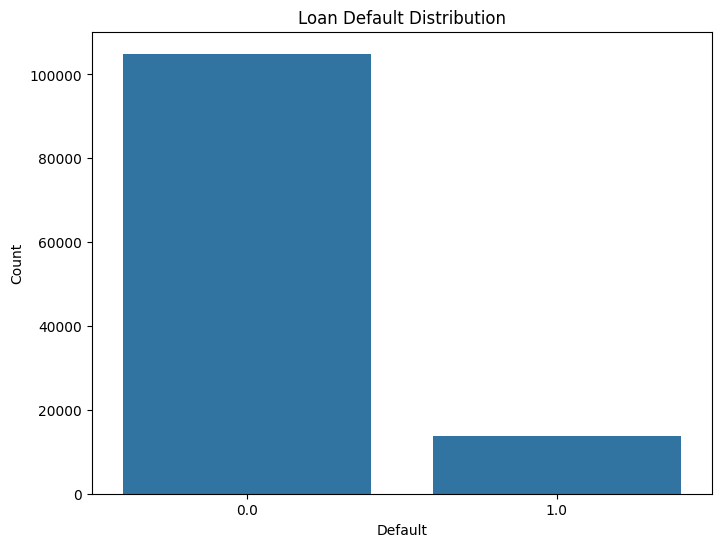

In [3]:
## further explore the dataset

# check for any missing values/nulls, etc..
print("\nMissing Values per column: ")
print(df.isnull().sum())

# get summary statistics
print("\nSummary statistics:")
print(df.describe())


# check the distribution of the target variable,(the loan default in this case)
print("\nTarget variable distribution:")
print(df['Default'].value_counts())
print(df['Default'].value_counts(normalize=True).round(4) * 100, "%")

# visualise the distribution of loan defaults
plt.figure(figsize=(8, 6))
sns.countplot(x='Default', data=df)
plt.title('Loan Default Distribution')
plt.ylabel('Count')
plt.show()


## Data Preprocessing and Cleaning

In [4]:
# identify the numerical and categorical features
numerical_features = ['Age', 'Income', 'LoanAmount', 'CreditScore',
                      'MonthsEmployed', 'NumCreditLines', 'InterestRate',
                      'LoanTerm', 'DTIRatio']

categorical_features = ['Education', 'EmploymentType', 'MaritalStatus',
                        'HasMortgage', 'HasDependents', 'LoanPurpose',
                        'HasCoSigner']


# check the categorical variables to understand their values
print("Examining categorical variables:")
for cat_feature in categorical_features:
    print(f"\n{cat_feature} value counts:")
    print(df[cat_feature].value_counts())

    print(f"Number of unique values: {df[cat_feature].nunique()}")


# identify and handle outliers in numerical features -- outliers affect logistic regression performance
# use IQR method to identify the outliers
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[ (df[column] < lower_bound) | (df[column] > upper_bound) ][column]

    return outliers.shape[0], lower_bound, upper_bound


# function to cap outliers to lower and upper bounds (winsorizing) -- this will help make the model's predictions more stable
def cap_outliers(df, column, lower_bound, upper_bound):
    df_copy = df.copy()
    df_copy[column] = df_copy[column].clip(lower=lower_bound, upper=upper_bound)

    return df_copy



# use the functions above to cap any outliers in numerical cols if they exist
print("\nOutlier Detection and Treatment:")
for col in numerical_features:
    # check for outliers
    outlier_count, lower_bound, upper_bound = identify_outliers(df, col)
    total_observations = len(df)
    outlier_percentage = (outlier_count / total_observations) * 100

    # print outlier stats for the current column
    print(f"{col}: {outlier_count} outliers ({outlier_percentage:.2f}% of data)")

    # can any outliers if they exist
    if outlier_count > 0:
        df = cap_outliers(df, col, lower_bound, upper_bound)

        print(f"  - Capped to range: [{lower_bound:.2f}, {upper_bound:.2f}]")





Examining categorical variables:

Education value counts:
Education
Bachelor's     29886
High School    29727
PhD            29569
Master's       29405
Name: count, dtype: int64
Number of unique values: 4

EmploymentType value counts:
EmploymentType
Self-employed    29770
Part-time        29761
Full-time        29585
Unemployed       29471
Name: count, dtype: int64
Number of unique values: 4

MaritalStatus value counts:
MaritalStatus
Divorced    39602
Single      39535
Married     39450
Name: count, dtype: int64
Number of unique values: 3

HasMortgage value counts:
HasMortgage
Yes    59295
No     59292
Name: count, dtype: int64
Number of unique values: 2

HasDependents value counts:
HasDependents
No     59404
Yes    59183
Name: count, dtype: int64
Number of unique values: 2

LoanPurpose value counts:
LoanPurpose
Business     23963
Home         23769
Other        23667
Auto         23631
Education    23557
Name: count, dtype: int64
Number of unique values: 5

HasCoSigner value counts:
H

In [5]:
# check the values in each category
print("\nChecking actual values in categorical columns:")
for cat_feature in categorical_features:
    print(f"\n{cat_feature} unique values:")
    print(df[cat_feature].unique())

# define mapping functions with error handling
def safe_map(series, mapping_dict):
    # make a copy to avoid modifying the original series
    result = series.copy()

    # apply mapping only to values that exist in the mapping dictionary we created
    for old_val, new_val in mapping_dict.items():
        result = result.replace(old_val, new_val)

    return result


# After checking the actual values, adjust the mappings to match dataset
df['Education'] = safe_map(df['Education'], { 'High School': 0, "Bachelor's": 1, "Master's": 2, "PhD": 3})

df['EmploymentType'] = safe_map(df['EmploymentType'], {'Unemployed': 0, 'Self-employed': 1, 'Full-time': 2, 'Part-time': 3})

df['MaritalStatus'] = safe_map(df['MaritalStatus'], {'Single': 0, 'Married': 1, 'Divorced': 2})

df['HasMortgage'] = safe_map(df['HasMortgage'], {'No': 0, 'Yes': 1})

df['HasDependents'] = safe_map(df['HasDependents'], {'No': 0, 'Yes': 1})

df['HasCoSigner'] = safe_map(df['HasCoSigner'], {'No': 0, 'Yes': 1})


# Verify that the mapping worked correctly
print("\nVerifying categorical mappings:")
for cat_feature in categorical_features:
    if cat_feature != 'LoanPurpose':  # Skip LoanPurpose as it uses cat.codes
        print(f"\n{cat_feature} value counts after mapping:")
        print(df[cat_feature].value_counts())

# The LoanPurpose column conversion is already working correctly
df['LoanPurpose'] = df['LoanPurpose'].astype('category').cat.codes




Checking actual values in categorical columns:

Education unique values:
["Bachelor's" "Master's" 'High School' 'PhD' nan]

EmploymentType unique values:
['Full-time' 'Unemployed' 'Self-employed' 'Part-time' nan]

MaritalStatus unique values:
['Divorced' 'Married' 'Single' nan]

HasMortgage unique values:
['Yes' 'No' nan]

HasDependents unique values:
['Yes' 'No' nan]

LoanPurpose unique values:
['Other' 'Auto' 'Business' 'Home' 'Education' nan]

HasCoSigner unique values:
['Yes' 'No' nan]

Verifying categorical mappings:

Education value counts after mapping:
Education
1.0    29886
0.0    29727
3.0    29569
2.0    29405
Name: count, dtype: int64

EmploymentType value counts after mapping:
EmploymentType
1.0    29770
3.0    29761
2.0    29585
0.0    29471
Name: count, dtype: int64

MaritalStatus value counts after mapping:
MaritalStatus
2.0    39602
0.0    39535
1.0    39450
Name: count, dtype: int64

HasMortgage value counts after mapping:
HasMortgage
1.0    59295
0.0    59292
Name: 

In [6]:
# check for duplicate rows of data
duplicate_count = df.duplicated().sum()
print(f"\nFound {duplicate_count} duplicate rows")

if duplicate_count > 0:
    # Remove duplicates
    df = df.drop_duplicates()
    print(f"Removed {duplicate_count} duplicate rows")



Found 0 duplicate rows


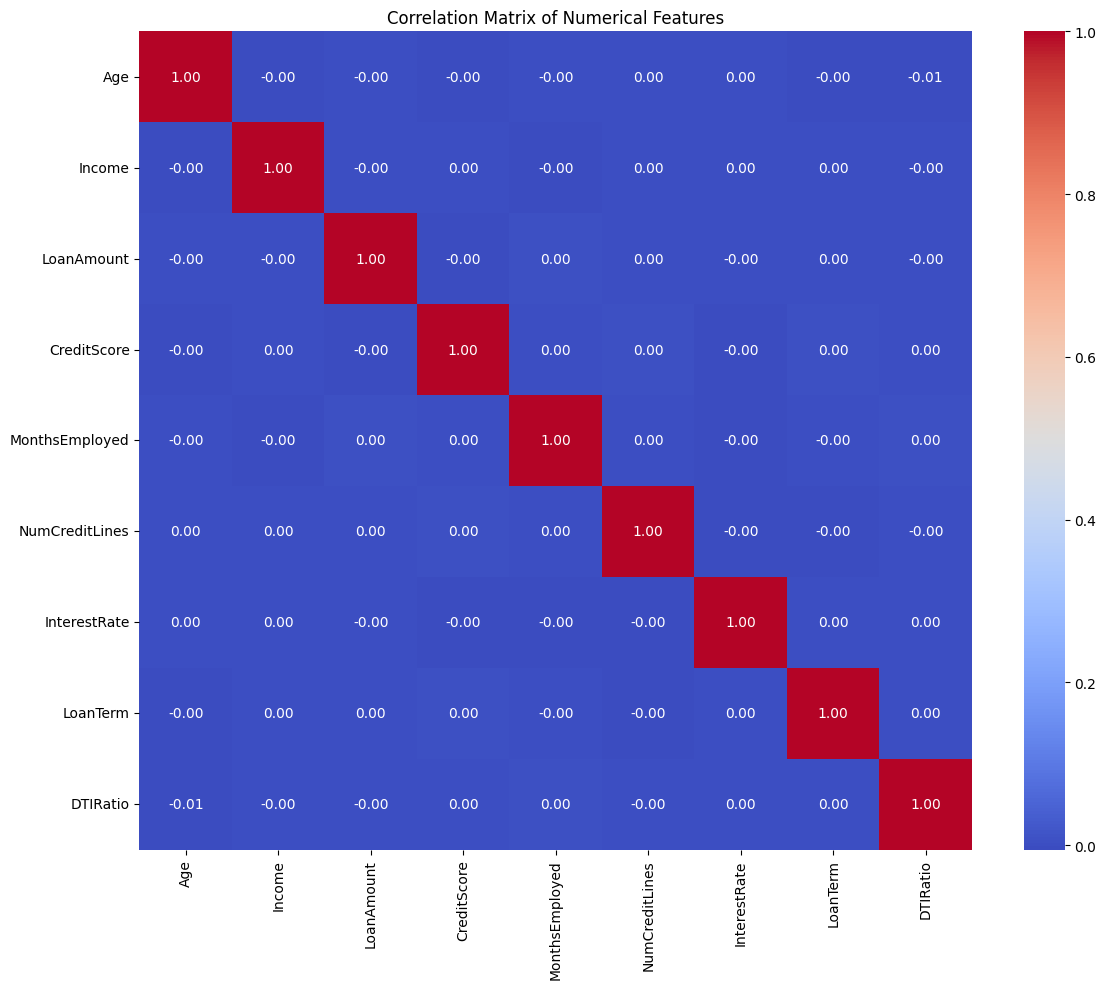

In [7]:
# examine the correlation between numerical features

# create a figure
plt.figure(figsize=(12, 10))

# compute the matrix
correlation_matrix = df[numerical_features].corr()

# generate the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# add title and adjust layout
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()

# display the plot
plt.show()

In [8]:
# Print a summary of the preprocessing steps performed
print("\nSummary of Preprocessing Steps:")
print("1. Identified numerical and categorical features")
print("2. Examined categorical variables")
print("3. Detected and capped outliers in numerical features")
print("4. Converted binary categorical variables to 0/1 format (if needed)")
print("5. Checked for and removed duplicate rows (if any)")
print("6. Examined correlations between numerical features")

# Show the dataset shape after preprocessing
print(f"\nDataset shape after preprocessing: {df.shape}")

# Check a sample of the preprocessed data
print("\nSample of preprocessed data:")
df.sample(20)


Summary of Preprocessing Steps:
1. Identified numerical and categorical features
2. Examined categorical variables
3. Detected and capped outliers in numerical features
4. Converted binary categorical variables to 0/1 format (if needed)
5. Checked for and removed duplicate rows (if any)
6. Examined correlations between numerical features

Dataset shape after preprocessing: (118588, 18)

Sample of preprocessed data:


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
109172,CFSR220YG4,69,135080,157004,649,108,3,23.29,24.0,0.29,0.0,3.0,0.0,0.0,1.0,2,0.0,0.0
80696,VG1BCZDF1Y,42,125822,49036,307,17,4,3.26,60.0,0.77,1.0,2.0,0.0,1.0,0.0,4,1.0,0.0
21436,ENXVCTNW0T,29,30719,72260,353,73,1,20.35,36.0,0.34,0.0,0.0,1.0,0.0,1.0,1,0.0,1.0
62199,8OHSYK52NA,56,142043,184936,458,90,1,16.56,36.0,0.30,2.0,1.0,0.0,1.0,0.0,1,1.0,0.0
116980,7FEZ2NZXKN,67,74847,146233,652,113,4,15.19,12.0,0.38,3.0,2.0,0.0,1.0,0.0,1,1.0,0.0
52508,GYDYSMF5CG,18,54641,175806,580,64,1,23.08,24.0,0.24,1.0,3.0,0.0,0.0,0.0,1,0.0,0.0
61846,CGVRR8990B,42,55971,200766,771,109,2,19.32,36.0,0.73,1.0,3.0,1.0,0.0,1.0,1,1.0,0.0
50956,YV0K9D32UH,59,112634,246295,308,113,4,17.66,60.0,0.44,2.0,2.0,2.0,1.0,0.0,4,0.0,0.0
4812,9F0TCP2LYM,36,64557,183002,488,104,3,16.09,12.0,0.73,1.0,0.0,2.0,0.0,0.0,4,0.0,0.0
19265,4WNC21Z6HS,40,72127,192156,554,79,4,11.10,60.0,0.11,3.0,2.0,1.0,1.0,0.0,0,1.0,0.0


## Feature Engineering

In [ ]:
# Measures creditworthiness per dollar borrowed.
df['CreditScoreToLoanRatio'] = df['CreditScore'] / df['LoanAmount']
print("Created: CreditScoreToLoanRatio")



# monthly payment calculation using the fixed-rate loan formula.
# PMT = P * (r*(1+r)^n) / ((1+r)^n - 1)  --> P = LoanAmount, r = MonthlyInterestRate, n = LoanTerm (in months)
df['MonthlyInterestRate'] = df['InterestRate'] / 100 / 12  # Convert annual % to monthly decimal rate

df['MonthlyPayment'] = df['LoanAmount'] * (
    df['MonthlyInterestRate'] * (1 + df['MonthlyInterestRate']) ** df['LoanTerm']
) / ((1 + df['MonthlyInterestRate']) ** df['LoanTerm'] - 1)

print("Created: MonthlyPayment")



# PaymentToIncomeRatio -- Assesses affordability by showing the percentage of annual income that goes toward loan payments.
df['PaymentToIncomeRatio'] = (df['MonthlyPayment'] * 12) / df['Income']
print("Created: PaymentToIncomeRatio")



# EmploymentToLoanTermRatio -- Indicates employment stability relative to the loan term.
df['EmploymentToLoanTermRatio'] = df['MonthsEmployed'] / df['LoanTerm']
print("Created: EmploymentToLoanTermRatio")



# AgeCreditInteraction -- Captures interaction effects between age and credit score.
# Dividing by 1000 scales the product for stability.
df['AgeCreditInteraction'] = (df['Age'] * df['CreditScore']) / 1000
print("Created: AgeCreditInteraction")



# DebtBurden -- Combines DTIRatio with income to reflect financial strain.
# logarithmic transformation of Income to reduce skewness and get a more stable measure.

# Lower income increases the burden even for similar DTIRatio values.
df['DebtBurden'] = df['DTIRatio'] * (1 - (np.log(df['Income']) / np.log(df['Income'].max())))
print("Created: DebtBurden with log-transformed income")



# AgeGroup (Binning) -- bins ages into categories to capture non-linear effects.
age_bins = [0, 25, 35, 45, 55, 65, 100]
age_labels = ['<25', '25-35', '35-45', '45-55', '55-65', '65+']
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

# Convert the categorical bins to numeric codes for modeling
df['AgeGroup'] = df['AgeGroup'].astype('category').cat.codes
print("Created: AgeGroup")






Created: CreditScoreToLoanRatio
Created: MonthlyPayment
Created: PaymentToIncomeRatio
Created: EmploymentToLoanTermRatio
Created: AgeCreditInteraction
Created: DebtBurden with log-transformed income
Created: AgeGroup



NaN counts after feature engineering:
Series([], dtype: int64)

Summary statistics of engineered features:
       CreditScoreToLoanRatio  MonthlyPayment  PaymentToIncomeRatio  \
count           255347.000000   255347.000000         255347.000000   
mean                 0.009184     5649.062363              1.157286   
std                  0.014196     4731.401956              1.466405   
min                  0.001205       90.802843              0.008192   
25%                  0.002989     2317.463583              0.336087   
50%                  0.004502     4442.059863              0.682542   
75%                  0.008685     7259.845864              1.397868   
max                  0.167853    23735.666660             18.086068   

       EmploymentToLoanTermRatio  AgeCreditInteraction     DebtBurden  \
count              255347.000000         255347.000000  255347.000000   
mean                    2.264673             24.978221       0.031235   
std                     2.125724 

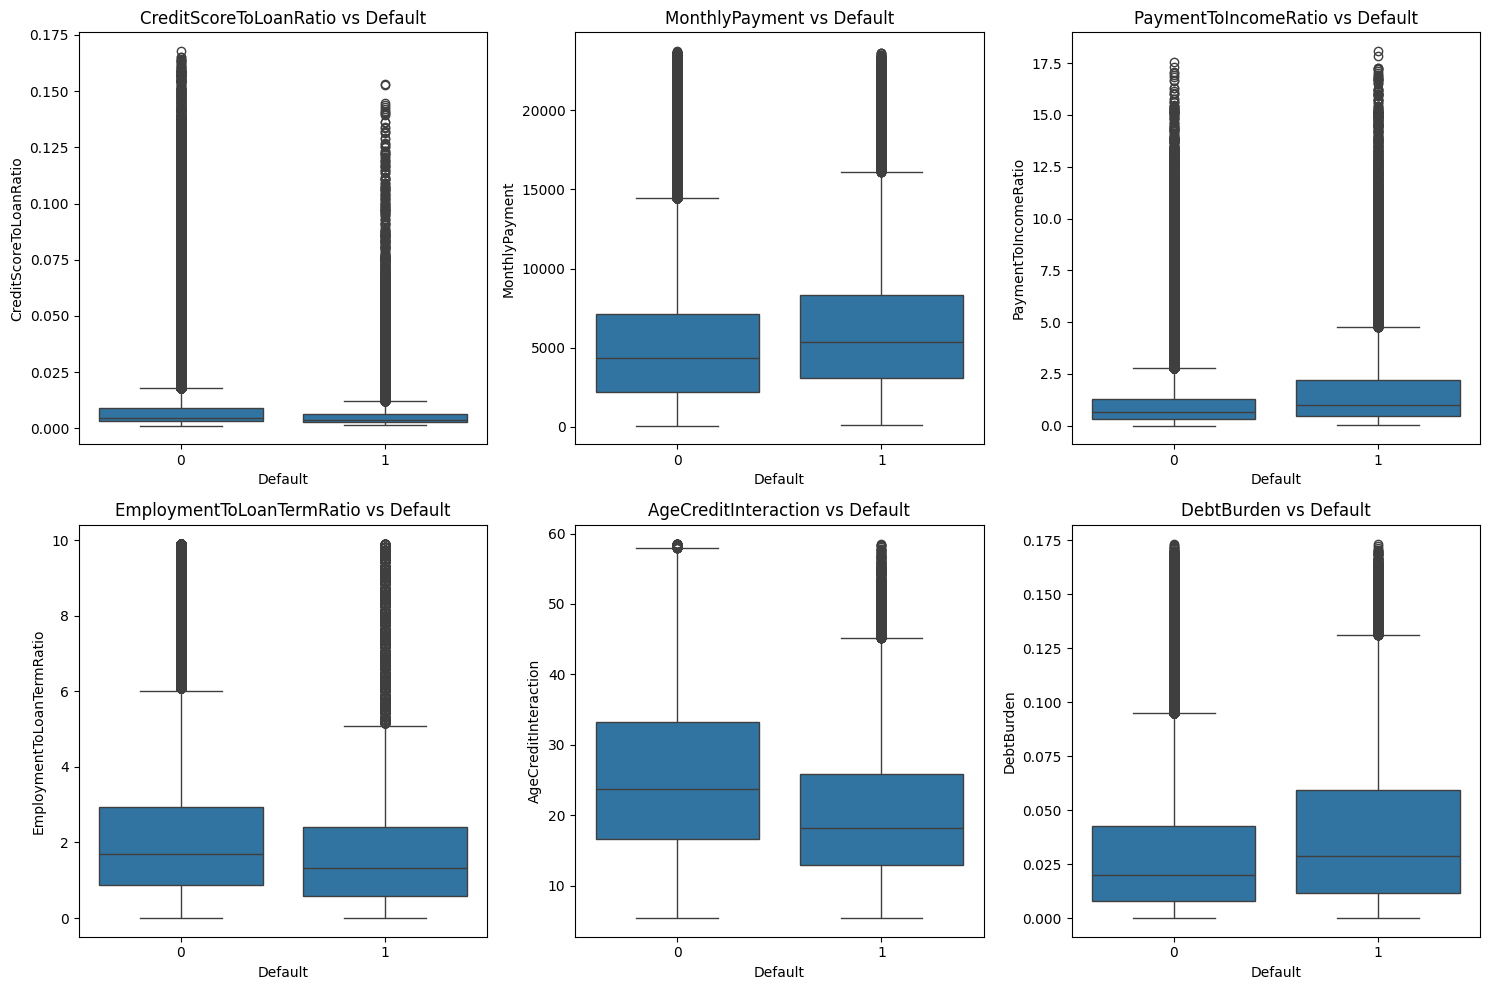

In [ ]:
# check for any NaN values created during this feature engineering process
nan_counts = df.isna().sum()
print("\nNaN counts after feature engineering:")
print(nan_counts[nan_counts > 0])  # Only list columns with NaN values


# handle any NaN values (if any)
if nan_counts.sum() > 0:
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())
    print("Filled NaN values in numerical columns with medians")




## visualise and summarise engineered features
# Explore the distribution of new features
engineered_features = [
    'CreditScoreToLoanRatio', 'MonthlyPayment', 'PaymentToIncomeRatio',
    'EmploymentToLoanTermRatio', 'AgeCreditInteraction', 'DebtBurden', 'AgeGroup'
]

print("\nSummary statistics of engineered features:")
print(df[engineered_features].describe())




# Visualize relationships between new features and the target variable
plt.figure(figsize=(15, 10))

# Exclude AgeGroup since it's categorical
for i, feature in enumerate(engineered_features[:6]):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='Default', y=feature, data=df)
    plt.title(f'{feature} vs Default')

plt.tight_layout()
plt.show()


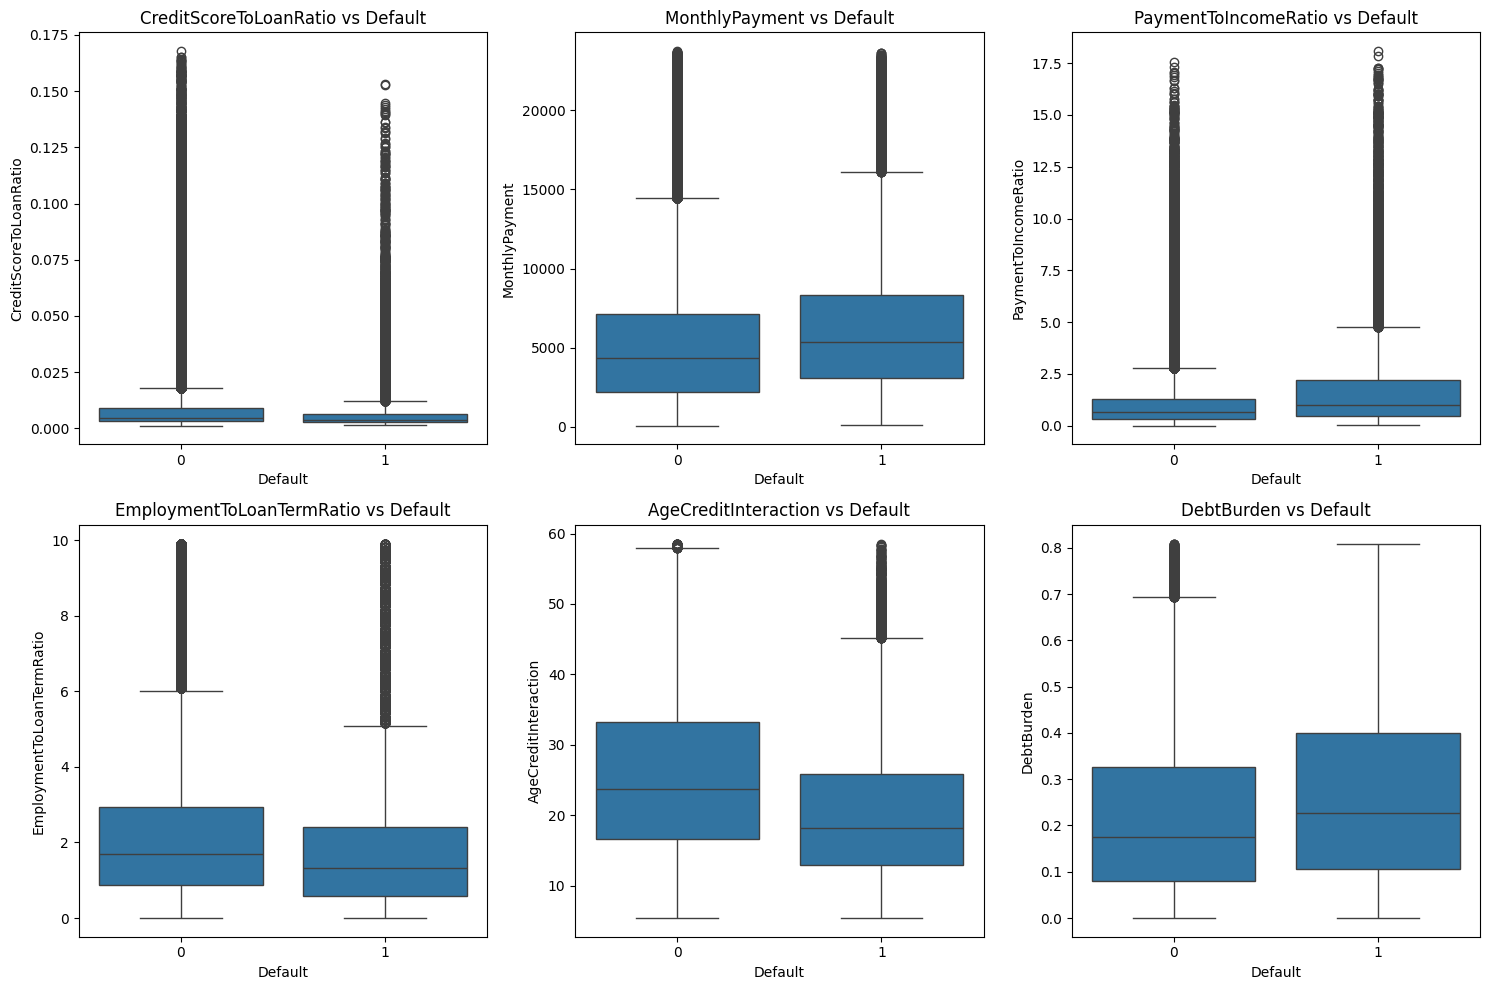

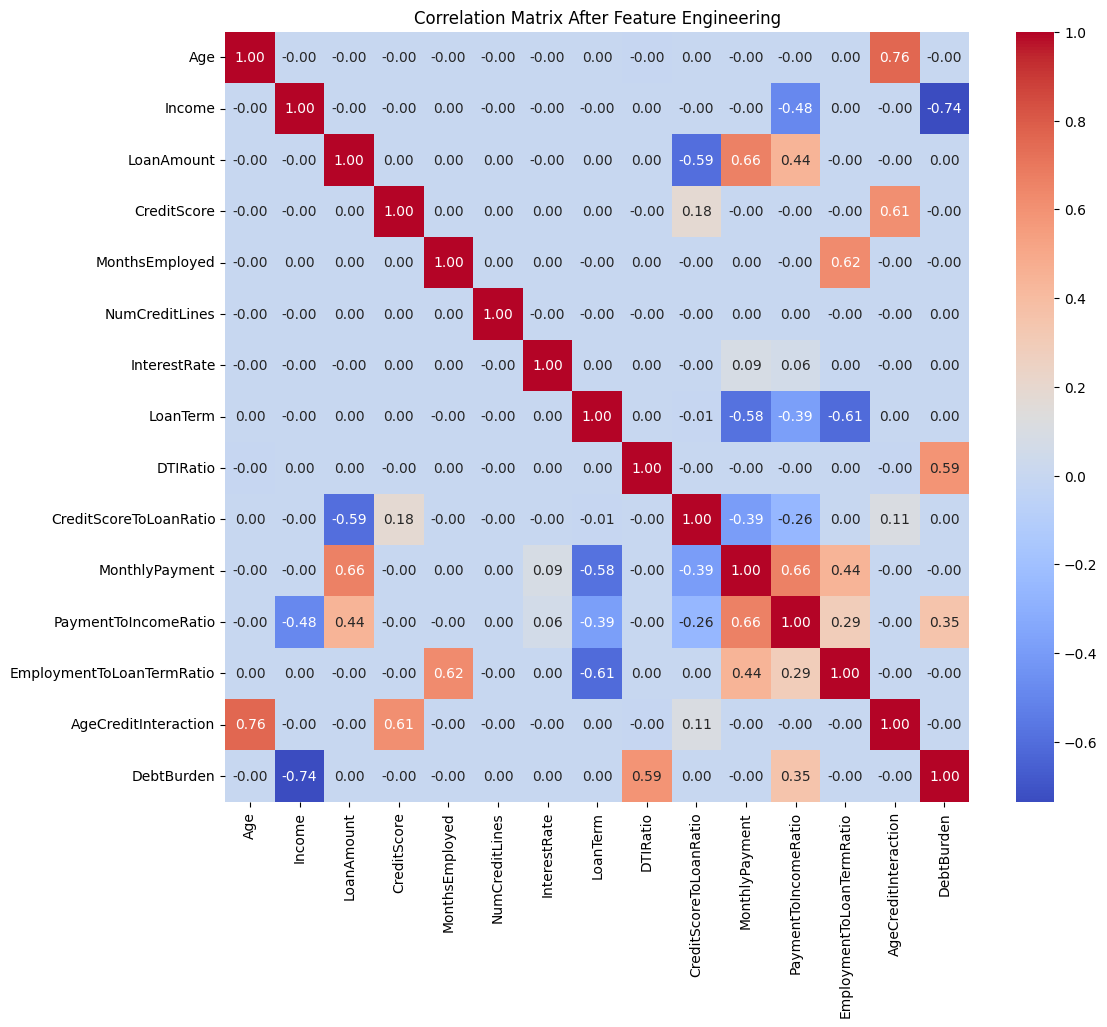


Highly correlated feature pairs (>0.75):
Age and AgeCreditInteraction: 0.76

Feature Engineering Summary:
Original features: 16
New features created: 7
Total features for modeling: 23
Highly correlated pairs: 1

Processed dataset shape: (255347, 26)
Sample of processed data:
            LoanID  Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
66890   JCG6ALL3IR   64   59546      224071          324              46   
144206  R4G4QIZX1B   35  138115      198273          564              68   
42256   PMYIFF7YM3   22   44366       29090          466              94   

        NumCreditLines  InterestRate  LoanTerm  DTIRatio  ...  HasCoSigner  \
66890                2          5.58        60      0.58  ...            0   
144206               1          7.09        36      0.15  ...            1   
42256                1         17.55        36      0.76  ...            0   

        Default  CreditScoreToLoanRatio  MonthlyInterestRate  MonthlyPayment  \
66890         1          

In [ ]:
## Update feature lists for modeling

# Original numerical features plus new engineered ones
updated_numerical_features = numerical_features + [
    'CreditScoreToLoanRatio', 'MonthlyPayment', 'PaymentToIncomeRatio',
    'EmploymentToLoanTermRatio', 'AgeCreditInteraction', 'DebtBurden'
]

# Original categorical features plus AgeGroup
updated_categorical_features = categorical_features + ['AgeGroup']



## address Multicollinearity

# Check correlation matrix for updated numerical features.
correlation_matrix = df[updated_numerical_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix After Feature Engineering')
plt.show()

print("\nHighly correlated feature pairs (>0.75):")
high_corr_pairs = []
for i in range(len(updated_numerical_features)):
    for j in range(i + 1, len(updated_numerical_features)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.75:
            high_corr_pairs.append((updated_numerical_features[i], updated_numerical_features[j], corr_value))
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")




# Summarize the feature engineering process
print("\nFeature Engineering Summary:")
print(f"Original features: {len(numerical_features) + len(categorical_features)}")
print(f"New features created: {len(engineered_features)}")
total_features = len(updated_numerical_features) + len(updated_categorical_features)
print(f"Total features for modeling: {total_features}")
print(f"Highly correlated pairs: {len(high_corr_pairs)}")

# Save the processed dataset for model training
df_processed = df.copy()
print("\nProcessed dataset shape:", df_processed.shape)
print("Sample of processed data:")
print(df_processed.sample(3))

In [ ]:
# considering that the correlation between Age and AgeCreditInteraction: 0.76, can remove one to improve model stability.
print("\nRemoving AgeCreditInteraction due to high correlation with Age (0.76)")
updated_numerical_features.remove('AgeCreditInteraction')

# Verify the update
print(f"Updated numerical features count: {len(updated_numerical_features)}")



Removing AgeCreditInteraction due to high correlation with Age (0.76)
Updated numerical features count: 14


## Data Splitting and Model Implementation

In [ ]:
# Prepare Features and Target Variables


# Remove columns that are not needed for modeling
features_to_drop = ['LoanID', 'MonthlyInterestRate']  # Add other non-feature columns as needed
model_df = df_processed.drop(columns=features_to_drop, errors='ignore')



# Separate the predictor variables (X) and the target variable (y)
X = model_df.drop('Default', axis=1)
y = model_df['Default']

print("Feature set shape:", X.shape)
print("Target variable shape:", y.shape)

Feature set shape: (226402, 23)
Target variable shape: (226402,)


In [ ]:

# split Data into Training and Testing Sets
# stratification ensures that the training and testing sets maintain the same default rate
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")



# Check class distribution in training and testing sets
print("\nClass distribution:")
print("Training set:")
print(pd.Series(y_train).value_counts(normalize=True).round(4) * 100, "%")
print("Testing set:")
print(pd.Series(y_test).value_counts(normalize=True).round(4) * 100, "%")



# Identify Numerical and Categorical Columns

# After preprocessing, most categorical columns should already be numeric.
# However, we extract any remaining categorical (object or category) columns.
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nNumerical features: {len(numerical_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

# --- Ensure uniform data types for categorical columns ---
# Convert all values in the categorical columns to strings to avoid mixed types
for col in categorical_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)


Training set: 181121 samples
Testing set: 45281 samples

Class distribution:
Training set:
Default
0.0    88.38
1.0    11.62
Name: proportion, dtype: float64 %
Testing set:
Default
0.0    88.39
1.0    11.61
Name: proportion, dtype: float64 %

Numerical features: 20
Categorical features: 1


In [ ]:
# Create Preprocessing Pipelines
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Pipeline for numerical data: impute missing values (median) and scale features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


# Pipeline for categorical data: impute missing values (most frequent) and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


# Combine numerical and categorical pipelines into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'  # Pass through any columns not explicitly processed
)



# Create a Pipeline with Logistic Regression ---
from sklearn.linear_model import LogisticRegression

# build a full pipeline: first preprocess the data, then apply logistic regression
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='elasticnet',   # Use elasticnet regularization (mix of L1 and L2)
        solver='saga',          # 'saga' is required for elasticnet penalty
        max_iter=1000,          # Increase iterations to ensure convergence
        random_state=42,
        class_weight='balanced' # Adjusts for class imbalance
    ))
])

In [ ]:

#  Set Up Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define hyperparameters for logistic regression to search over
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],   # Inverse regularization strength
    'classifier__l1_ratio': [0.1, 0.5, 0.9]             # Balance between L1 (sparse) and L2 (ridge)
}

# Set up cross-validation that preserves class distribution (stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configure GridSearchCV to search for the best hyperparameters using ROC AUC as metric
grid_search = GridSearchCV(
    log_reg_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',   # Use ROC AUC to evaluate performance
    verbose=1,
    n_jobs=-1            # Utilize all available CPU cores
)

In [ ]:

# Train the Model with Grid Search
print("\nTraining logistic regression model with hyperparameter tuning...")
print("This may take a few minutes...")
grid_search.fit(X_train, y_train)


Training logistic regression model with hyperparameter tuning...
This may take a few minutes...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Income',
                                                                          'LoanAmount',
                                                                          'CreditScore',
                                                                          'MonthsEmployed',
                                                                          'NumCreditLines',
                                                                          'Int...
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['EmploymentType'])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           penalty='elasticnet',
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__l1_ratio': [0.1, 0.5, 0.9]},
             scoring='roc_auc', verbose=1)


Best parameters found:
{'classifier__C': 0.1, 'classifier__l1_ratio': 0.9}
Best cross-validation score (ROC AUC): 0.7508

Top 5 parameter combinations:
                                              params  mean_test_score  \
8  {'classifier__C': 0.1, 'classifier__l1_ratio':...         0.750832   
3  {'classifier__C': 0.01, 'classifier__l1_ratio'...         0.750830   
4  {'classifier__C': 0.01, 'classifier__l1_ratio'...         0.750830   
7  {'classifier__C': 0.1, 'classifier__l1_ratio':...         0.750826   
6  {'classifier__C': 0.1, 'classifier__l1_ratio':...         0.750820   

   std_test_score  rank_test_score  
8        0.002743                1  
3        0.002754                2  
4        0.002782                3  
7        0.002742                4  
6        0.002743                5  


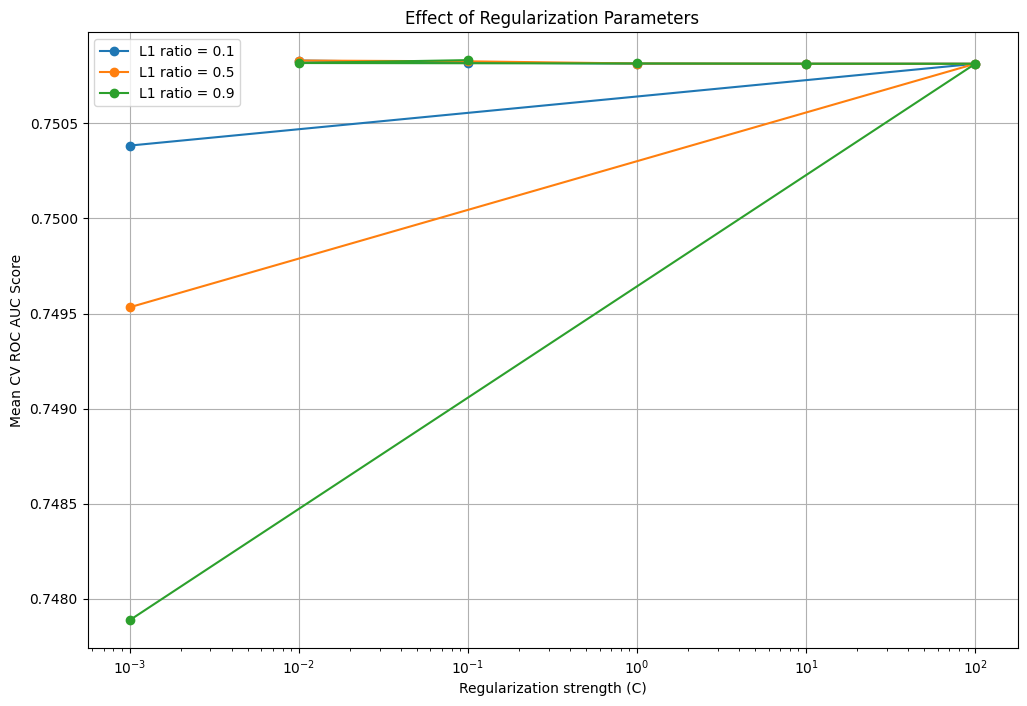


Logistic Regression model training complete!
Next step: Evaluate model performance on the test set.


In [ ]:

# Report the Best Hyperparameters and CV Score ---
print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation score (ROC AUC): {grid_search.best_score_:.4f}")



# Retrieve the Best Model ---
best_model = grid_search.best_estimator_


# Examine Detailed CV Results ---
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')
print("\nTop 5 parameter combinations:")
cols_to_show = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
print(cv_results[cols_to_show].head())



# Visualize Hyperparameter Performance
# Plot how the cross-validation score varies with different regularization strengths and l1 ratios
c_values = param_grid['classifier__C']
l1_ratios = param_grid['classifier__l1_ratio']


# Extract the relevant parameters from cv_results
cv_results['C'] = cv_results['param_classifier__C']
cv_results['l1_ratio'] = cv_results['param_classifier__l1_ratio']

plt.figure(figsize=(12, 8))
for l1_ratio in l1_ratios:
    subset = cv_results[cv_results['l1_ratio'] == l1_ratio]
    plt.semilogx(subset['C'], subset['mean_test_score'],
                 marker='o', label=f'L1 ratio = {l1_ratio}')
plt.xlabel('Regularization strength (C)')
plt.ylabel('Mean CV ROC AUC Score')
plt.title('Effect of Regularization Parameters')
plt.legend()
plt.grid(True)
plt.show()

print("\nLogistic Regression model training complete!")
print("Next step: Evaluate model performance on the test set.")